# Sediment Thick Analysis

### Load dataset and declare indices of variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import geo_preprocess3
from tabulate import tabulate
% matplotlib inline

# load data
data = np.genfromtxt('alldata_new', delimiter='')

# define column index for 19 variables
lon_ind = 0
lat_ind = 1
sedthick_ind = 2
sedrate_ind = 3   
age_ind = 4
passive_dis_ind = 5
amazon_dis_ind = 6
congo_dis_ind = 7
gange_dis_ind = 8
godava_dis_ind = 9
indus_dis_ind = 10
magdalena_dis_ind = 11
mahan_dis_ind = 12
missi_dis_ind = 13
narma_dis_ind = 14
niger_dis_ind = 15
orin_dis_ind = 16
paleo_dis_ind = 17
parana_dis_ind = 18

river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, paleo_dis_ind, parana_dis_ind])

river_names = np.array(['Amazon', 'Congo', 'Ganges-Bramaputra', 'Godavari-Krishna', 'Indus',
                        'Magdalena', 'Mahanadi', 'Mississipi', 'Narma', 'Niger', 'Orinoco',
                        'Paleo-Congo', 'Parana'])

print(river_indices)
data.shape

[ 6  7  8  9 10 11 12 13 14 15 16 17 18]


(34773, 19)

### Declare the regressor

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# number of splits for LongFold cross validation
n_splits = 3

# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

### Remove records where thick is 0, age is nan, and distance to passive is nan

In [3]:
# remove records where thick is zero
y = data[:, sedthick_ind]
data = data[~(y == 0)]

# remove records where age is nan
y = data[:, age_ind]
data = data[~np.isnan(y)]

# remove records where distance to passive margin is nan
y = data[:, passive_dis_ind]
data = data[~np.isnan(y)]

# remove records where sediment rate is nan or 0
sedrate = data[:, sedrate_ind]
index = (~np.isnan(sedrate)) & (~(sedrate == 0))
data = data[index]

# the final dataset has dimension as follows
data.shape

(27306, 19)

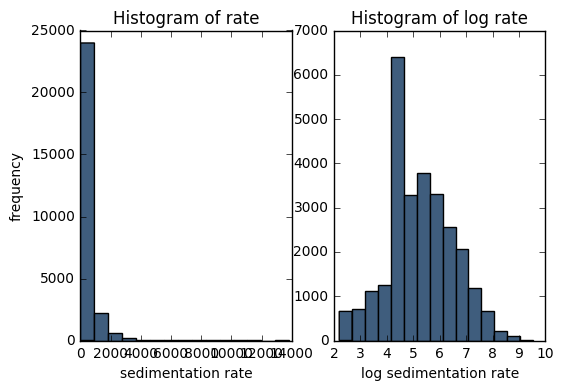

In [4]:
# plot histogram for sediment thick and log sediment thick
f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[:, [sedthick_ind]], color="#3F5D7D", bins=15)
ax2.hist(np.log(data[:, [sedthick_ind]]), color="#3F5D7D", bins=15)
ax1.set_xlabel('sedimentation rate')
ax1.set_ylabel('frequency')
ax2.set_xlabel('log sedimentation rate')
ax1.set_title('Histogram of rate')
ax2.set_title('Histogram of log rate')
plt.show()

In [5]:
# extract rivers from data based on river indices
rivers = data[:, river_indices]

# impute nan in rivers with inifinty
rivers[np.isnan(rivers)] = np.inf

# take the inverse of distance to rivers
irivers = 1.0 / rivers

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sediment thick
sedthick = data[:, sedthick_ind]

def compute_r2(weights):
    """
    Function to be optimzed later.
    
    Parameters
    ----------
    weights : ndarray (d, 1); the weights for rivers
    
    Return
    ------
    nr2 : float; the negative r square
    """
    nr2 = 0.0
    
    # square weights to make sure they are positive
    weights = weights ** 2

    # obtain weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * weights, axis=1)
    
    # integrate all features and target variable into one matrix - data2
    data2 = np.c_[data1, ws_river, sedthick]
    
    # do regression 
    # - this is a function in file geo_preprocess3
    # - it use longitude to do LongFold cross validation
    # - logy=True means apply log transform to target variable y
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedthick)
    
    # obtain negative r square of actual log rate and predicted log rate
    nr2 = -1.0 * r2_score(yactual, ypred)
    
    # print nr2 to see the process of optimization
    print(nr2)
    return nr2

from scipy.optimize import minimize

# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(13)

# here I comment out the command for launching optmization, it takes about 5 minutes to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt = opt ** 2
# print(tabulate(np.vstack([river_names, opt]).T))

### Use optmized weights to generate feature distance to rivers

In [6]:
# This is the optimal weights from optimization
opt_weights = np.array([
        0.0463644,
        0.00225269,
        1.2958,
        0.209888,
        0.0378268,
        2.39615,
        1.0464,
        0.002145,
        0.00326835,
        4.35545e-06,
        0.000313391,
        0.585559,
        2.66148
    ])

### Train model and do regression, plot goodness of fit

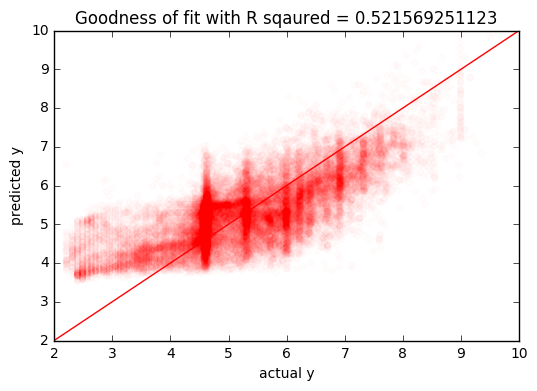

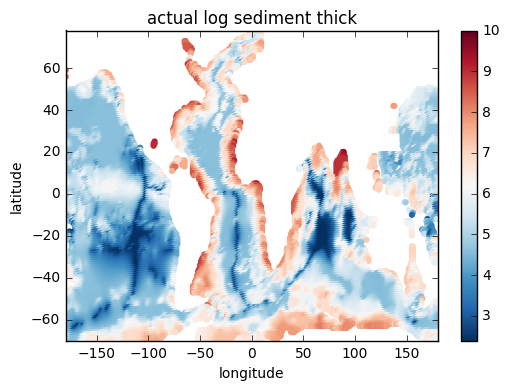

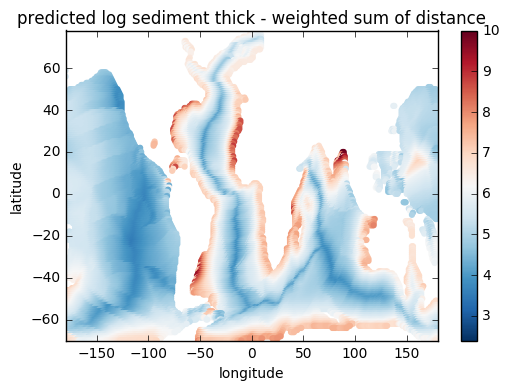

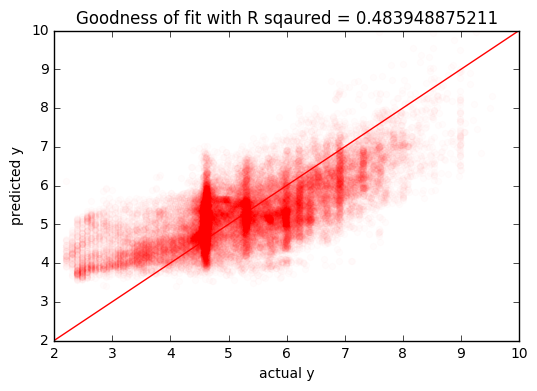

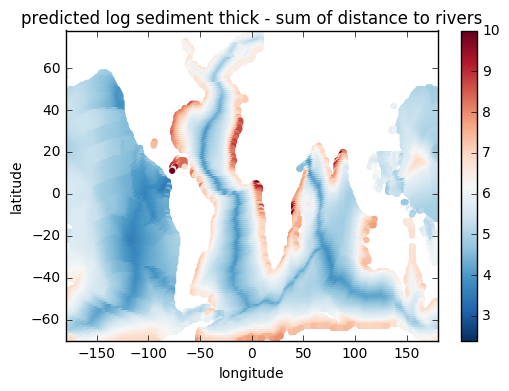

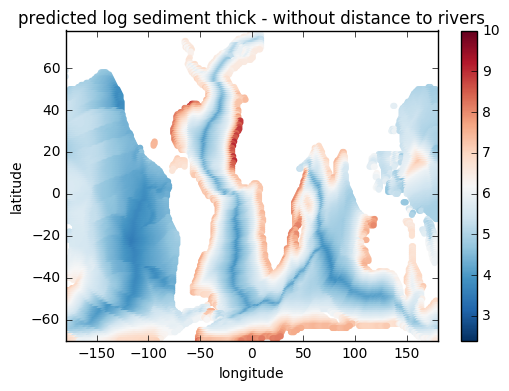

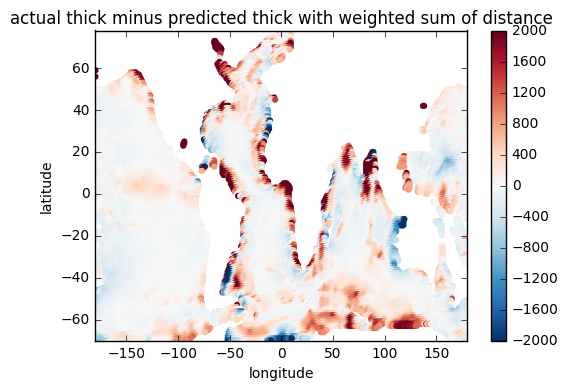

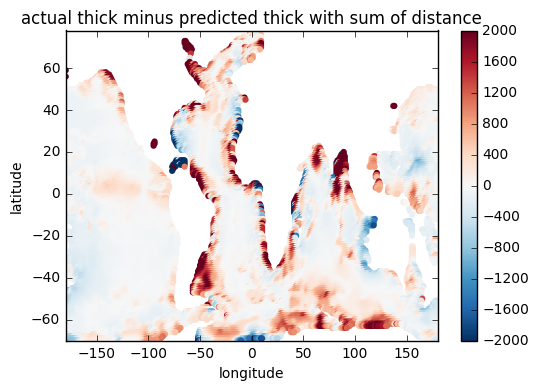

In [7]:
# take out rivers from data
rivers = data[:, river_indices]

# impute nan with infinty
rivers[np.isnan(rivers)] = np.inf

# apply inverse to distance to rivers
irivers = 1.0 / rivers

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)


# define the feature matrix along with target variable - sedrate
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
sedthick = data[:, sedthick_ind]
data2 = np.c_[data1, ws_river, sedthick]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred1, regressor_trained =  geo_preprocess3.regression(data=data2, 
                                    regressor=regressor, 
                                    n_splits=3,
                                    lon_ind=lon_ind, 
                                    lat_ind=lat_ind, 
                                    y_ind=-1,
                                    logy=True)

# regression2, without distance to rivers
# return predicted log rate and trained regressor
ypred2, _=  geo_preprocess3.regression(data=np.c_[data1, sedthick], 
                                    regressor=regressor, 
                                    n_splits=3,
                                    lon_ind=lon_ind, 
                                    lat_ind=lat_ind, 
                                    y_ind=-1,
                                    logy=True)

# regression3, with sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred3, _=  geo_preprocess3.regression(data=np.c_[data1, np.sum(irivers, 1), sedthick], 
                                    regressor=regressor, 
                                    n_splits=3,
                                    lon_ind=lon_ind, 
                                    lat_ind=lat_ind, 
                                    y_ind=-1,
                                    logy=True)


# extract longitude, latitude and sedthick for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedthick)

# scatterplot of ypred and yactual
geo_preprocess3.feature_scatter(yactual, ypred1, 
                               xlim1=2,
                               xlim2=10,
                               ylim1=2,
                               ylim2=10)

# global map of actual log sediment thick
geo_preprocess3.draw_global(c=yactual, 
                       title='actual log sediment thick',
                       longitude=lon, latitude=lat, 
                       vmin=10, 
                       vmax=2.4)

# global map of predicted log sediment thick from regression
geo_preprocess3.draw_global(c=ypred1, 
                       title='predicted log sediment thick - weighted sum of distance',
                       longitude=lon, latitude=lat, 
                       vmin=10, 
                       vmax=2.4)

# scatterplot of ypred and yactual
geo_preprocess3.feature_scatter(yactual, ypred3, 
                               xlim1=2,
                               xlim2=10,
                               ylim1=2,
                               ylim2=10)

# global map of predicted log sediment thick from regression with distance to rivers
geo_preprocess3.draw_global(c=ypred3, 
                       title='predicted log sediment thick - sum of distance to rivers',
                       longitude=lon, latitude=lat, 
                       vmin=10, 
                       vmax=2.4)

# global map of predicted log sediment thick from regression without distance to rivers
geo_preprocess3.draw_global(c=ypred2, 
                       title='predicted log sediment thick - without distance to rivers',
                       longitude=lon, latitude=lat, 
                       vmin=10, 
                       vmax=2.4)

# global map of difference between actual and predicted sediment thick
# i.e. actual sediment thick - exp(predicted log sediment thick)
geo_preprocess3.draw_global(c= (sedthick - np.exp(ypred1)), 
                       title='actual thick minus predicted thick with weighted sum of distance',
                       longitude=lon, latitude=lat, 
                       vmin=-2000, 
                       vmax=2000)

geo_preprocess3.draw_global(c= (sedthick - np.exp(ypred3)), 
                       title='actual thick minus predicted thick with sum of distance',
                       longitude=lon, latitude=lat, 
                       vmin=-2000, 
                       vmax=2000)

### Feature Analysis - Age

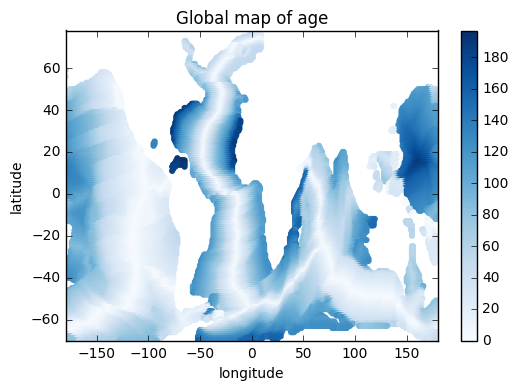

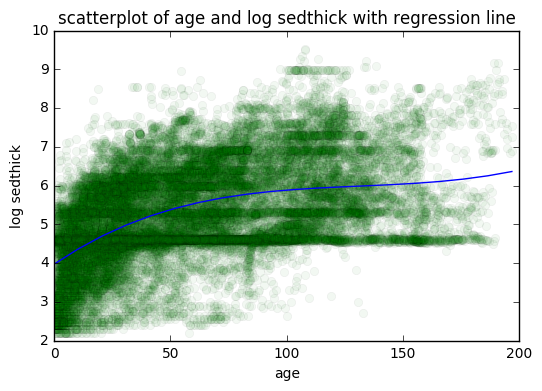

In [8]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of age
age = data[:, age_ind]
sedthick = data[:, sedthick_ind]
geo_preprocess3.draw_global(c=age, 
                            title='Global map of age',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=197, 
                            cmap='Blues')

# learn relationship between age and sedrate
regressor.fit(age.reshape(-1,1), np.log(sedthick))
fea_min = np.min(age)
fea_max = np.max(age)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of age and log sedrate
plt.plot(age, np.log(data[:, sedthick_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of age and log sedthick with regression line')
plt.xlabel('age')
plt.ylabel('log sedthick')
plt.ylim([2, 10])
plt.show()

### Feature Analysis - Distance to passive margin

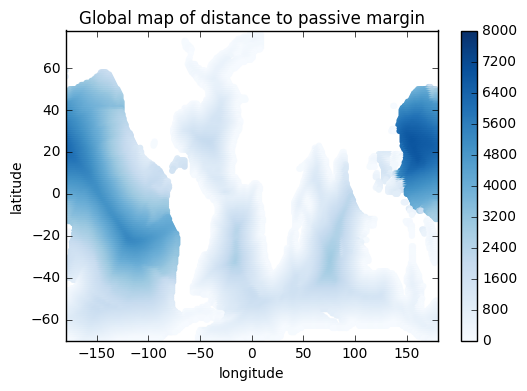

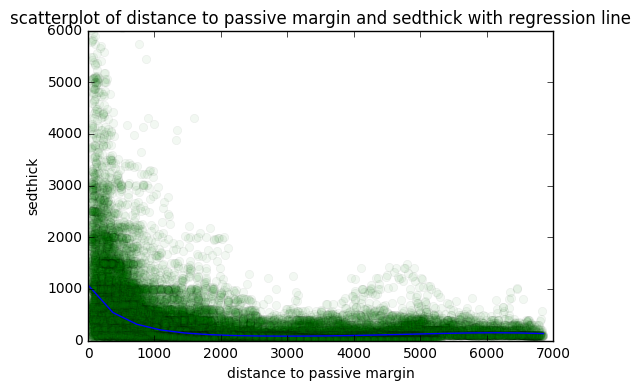

In [9]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of distance to passive margine
passive_dis = data[:, passive_dis_ind]
sedthick = data[:, sedthick_ind]
geo_preprocess3.draw_global(c=passive_dis, 
                            title='Global map of distance to passive margin',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=8000,
                            cmap='Blues')

# learn relationship between distance to passive margine and sedrate
regressor.fit(passive_dis.reshape(-1,1), np.log(sedthick))
fea_min = np.min(passive_dis)
fea_max = np.max(passive_dis)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of distance to passive margine and log sedrate
plt.plot(passive_dis, data[:, sedthick_ind], 'go', alpha=0.05, lw=0)
plt.plot(fea_query, np.exp(fea_pred), color='b')
plt.title('scatterplot of distance to passive margin and sedthick with regression line')
plt.xlabel('distance to passive margin')
plt.ylabel('sedthick')
plt.ylim([0, 6000])
plt.show()

### Feature Analysis - Weight sum of inverse of distance to rivers

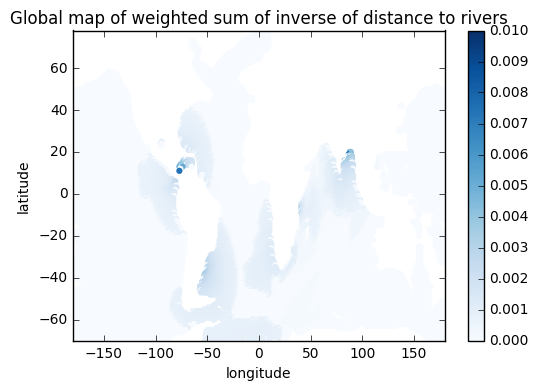

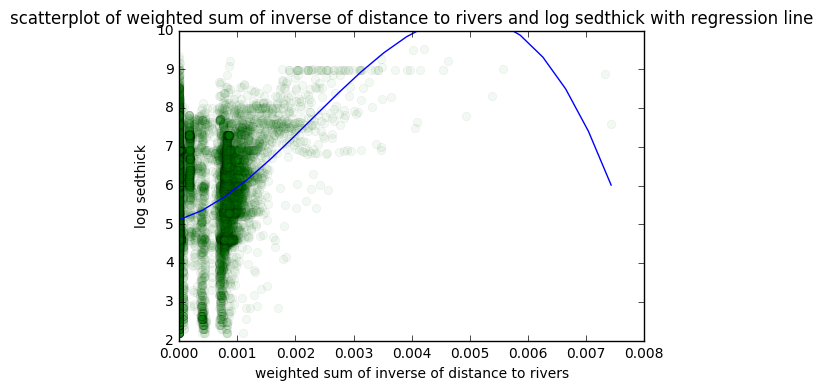

In [10]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of weighted sum of inverse of distance to rivers
rivers = data[:, river_indices]
rivers[np.isnan(rivers)] = np.inf
irivers = 1.0 / rivers
ws_river = np.sum(irivers * opt_weights, 1)

sedthick = data[:, sedthick_ind]
geo_preprocess3.draw_global(c=ws_river, 
                            title='Global map of weighted sum of inverse of distance to rivers',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=0.01,
                            cmap='Blues')

# learn relationship between weighted sum of inverse of distance to rivers and sedrate
regressor.fit(ws_river.reshape(-1,1), np.log(sedthick))
fea_min = np.min(ws_river)
fea_max = np.max(ws_river)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of weighted sum of inverse of distance to rivers and log sedrate
plt.plot(ws_river, np.log(data[:, sedthick_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of weighted sum of inverse of distance to rivers and log sedthick with regression line')
plt.xlabel('weighted sum of inverse of distance to rivers')
plt.ylabel('log sedthick')
plt.ylim([2, 10])
plt.show()